In [1]:
from dask_kubernetes import KubeCluster
from dask.distributed import Client, progress
import dask.array as da
import numpy as np
import pandas as pd
import zarr
import allel
import sys
import ag3
import psutil
from humanize import naturalsize
import numba

/opt/conda/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from ag3 import GenomeFigure

In [3]:
n_workers = 20

In [4]:
# cluster setup
cluster = KubeCluster()
cluster.scale_up(n_workers)

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:  tcp://10.33.122.87:34401
distributed.scheduler - INFO -   dashboard at:                     :8787


In [5]:
# dask client setup
client = Client(cluster)
client

distributed.scheduler - INFO - Receive client connection: Client-71780802-2285-11eb-8306-6a5003b01edc
distributed.core - INFO - Starting established connection


Client Scheduler: tcp://10.33.122.87:34401 Dashboard: /user/nicholasharding/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [6]:
# grab data from release
v3 = ag3.release_data()

In [7]:
meta_all = v3.load_sample_set_metadata(v3.all_wild_sample_sets)

distributed.scheduler - INFO - Register tcp://10.33.25.3:39225
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.25.3:39225
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.33.20.3:38721
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.20.3:38721
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.33.13.3:46209
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.13.3:46209
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.33.6.3:35093
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.6.3:35093
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.33.10.3:40469
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.10.3:40469
distributed.core - INFO -

In [10]:
count_ = meta_all.groupby(["sample_set", "location", "species_gambcolu_arabiensis"]).size()
count_by_loc = pd.pivot_table(count_.reset_index(), values=0, index=["sample_set", "location"], columns="species_gambcolu_arabiensis", fill_value=0)

In [11]:
loc_sites = (count_by_loc[["arabiensis", "gamb_colu"]] > 10).all(axis=1)
loc_sites

sample_set    location      
AG1000G-AO    Luanda            False
AG1000G-BF-A  Bana              False
              Pala              False
              Souroukoudinga    False
AG1000G-BF-B  Bana              False
                                ...  
AG1000G-TZ    Muheza            False
              Muleba             True
              Tarime            False
AG1000G-UG    Kihihi            False
              Nagongera          True
Length: 131, dtype: bool

In [12]:
sites_to_investigate= count_by_loc.loc[loc_sites].index
sites_to_investigate

MultiIndex([('AG1000G-KE',    'Kilifi'),
            ('AG1000G-TZ',    'Muleba'),
            ('AG1000G-UG', 'Nagongera')],
           names=['sample_set', 'location'])

In [13]:
def equally_accessible_chunks(is_accessible, window_size=50_000):
    
    if not isinstance(is_accessible, np.ndarray):
        is_accessible = np.array(is_accessible)
    
    cumsum = np.cumsum(is_accessible)
    z = ((cumsum % window_size) == 0) & (cumsum >= window_size)

    # only select cells that are multiples of window size **and** are not followed by another cell that contains the window size.
    same_follows = np.diff(z.astype(int), append=0) == 0

    ix = np.where(z & ~same_follows)[0] + 1

    _chunks = np.diff(ix, prepend=0)
    
    return tuple(_chunks), _chunks.sum()

In [14]:
@numba.njit
def dist_block(a, masked, ix, jx):
    
    """
    a: n_alts array
    masked: 1D mask of the same size in 0 axis.
    ix: indicies of the first population
    jx: indicies of the second population
    
    """
    
    diff_sum = np.zeros((ix.shape[0], jx.shape[0]), dtype=np.int32)
    diff_denom = np.zeros((ix.shape[0], jx.shape[0]), dtype=np.int32)
    
    for x in range(a.shape[0]):
        
        i_counter = 0

        # if site filtered by mask
        if not masked[x]:
            continue
    
        for i in ix:
            
            # if i is missing, do not bother to loop through j.
            if a[x, i] < 0:
                continue
            
            j_counter = 0

            for j in jx:

                # if j is missing continue with next j
                if a[x, j] < 0:
                    continue

                else:
                    diff_sum[i_counter, j_counter] += abs(a[x, i] - a[x, j])
                    diff_denom[i_counter, j_counter] += 2

                j_counter += 1

            i_counter += 1
            
    out = diff_sum / diff_denom

    return np.expand_dims(out, axis=0)

In [15]:
chromosomes = ["2L", "2R", "3L", "3R", "X"]

# loop through chroms first?
- one load of mask
- one id of windows
- more complex data storage?

In [16]:

# pre fill indices of interest
ix_species = {}
for sample_set_id, location_id in sites_to_investigate:
        
        meta_single = v3.load_sample_set_metadata(sample_set_id)
        
        ix_species[sample_set_id, location_id] = {
            "arab": np.where((meta_single.location == location_id) & (meta_single.species_gambcolu_arabiensis == "arabiensis").values)[0],
            "gambcolu": np.where((meta_single.location == location_id) & (meta_single.species_gambcolu_arabiensis == "gamb_colu").values)[0]
        }

In [21]:
pd_dict = {}
pos_dict = {}

for chrom in chromosomes:
    pd_dict[chrom] = {}
    
    # load sampleset independent data
    mask = v3.load_mask(chrom, 'gamb_colu_arab')
    chunk_sizes, end = equally_accessible_chunks(mask)
    
    # reshape and rechunk mask
    maskrc = mask[:end].reshape((-1, 1)).rechunk((chunk_sizes, (1,)))
    
    # load positions, and compute midpoints
    posi = v3.load_variants(chrom)

    midpoints = da.map_blocks(
        lambda y: np.median(y).reshape((1, 1)), 
        posi[:end].reshape((-1, 1)).rechunk((chunk_sizes, 1)),
        chunks=(1, 1)).compute().squeeze()

    pos_dict[chrom] = midpoints

    for sample_set_id, location_id in sites_to_investigate:
    
        ix_arab = ix_species[sample_set_id, location_id]["arab"]
        ix_gambcolu = ix_species[sample_set_id, location_id]["gambcolu"]
    
        # this doesn't handle multiallelic sites...
        g = v3.load_sample_set_calldata(chrom, sample_set_id)
        y = allel.GenotypeDaskArray(g).to_n_alt(fill=-1)

        # rechunk n_alts to ensure correct size
        yrc = y[:end].rechunk((chunk_sizes, y.shape[1]))

        q = da.map_blocks(
            dist_block, yrc, maskrc, dtype=np.float32, 
            chunks=(1, ix_arab.shape[0], ix_gambcolu.shape[0]), 
            drop_axis=(1,), new_axis=[1, 2], ix=ix_arab, jx=ix_gambcolu)

        pairwise_diff = q.compute()

        pd_dict[chrom][location_id] = np.percentile(pairwise_diff, (0, 1, 5, 25, 50, 75, 95, 99, 100), axis=(1, 2))

In [39]:
def draw_introgression_relative(chrom, ax, data, location=None):

    minimum = data[chrom][location][0]
    median = data[chrom][location][4]
    
    pos = pos_dict[chrom]
    
    ax.plot(pos, np.log2(median / minimum), label=location)
    ax.grid(True)
    ax.set_ylim(0, 3.5)

In [29]:
def draw_introgression(chrom, ax, data, location=None):

    minimum = data[chrom][location][0]
    median = data[chrom][location][4]
    
    pos = pos_dict[chrom]
    
    ax.plot(pos, minimum, label="Gmin")
    ax.plot(pos, median, label="Gmedian")
    ax.set_ylim(0, .02)

In [24]:
import fsspec
import zarr

In [25]:
genome_path_gcs = 'gs://vo_agam_release/reference/genome/agamp4/Anopheles-gambiae-PEST_CHROMOSOMES_AgamP4.zarr'
genome_store = fsspec.get_mapper(genome_path_gcs)
genome = zarr.open_consolidated(genome_store)
genome

<zarr.hierarchy.Group '/'>

In [26]:
list(genome.keys())

['2L', '2R', '3L', '3R', 'Mt', 'UNKN', 'X', 'Y_unplaced']

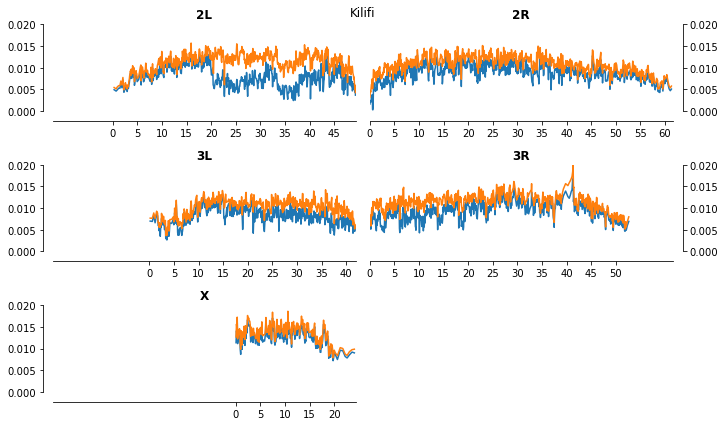

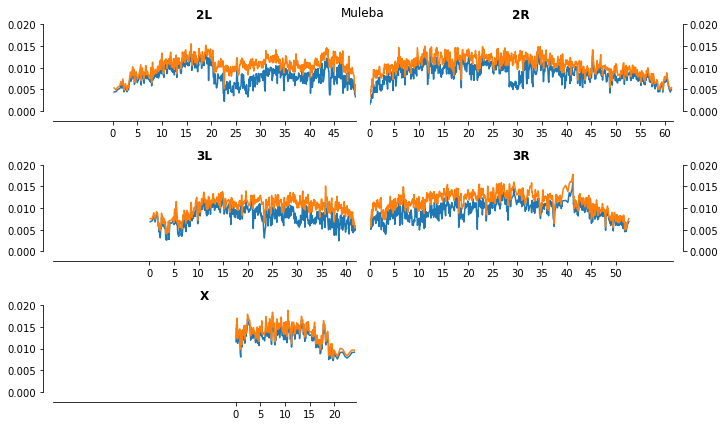

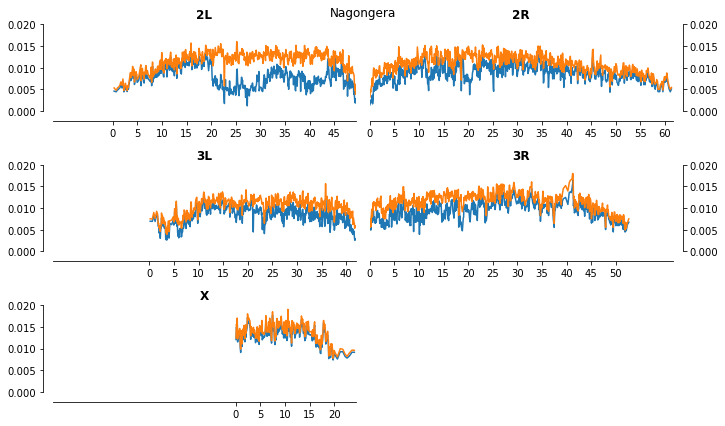

In [37]:
for _, location in sites_to_investigate:
    
    f = GenomeFigure(genome, chromosomes=chromosomes, figsize=(10, 6))
    f.apply(draw_introgression, data=pd_dict, location=location)
    f.fig.suptitle(location)

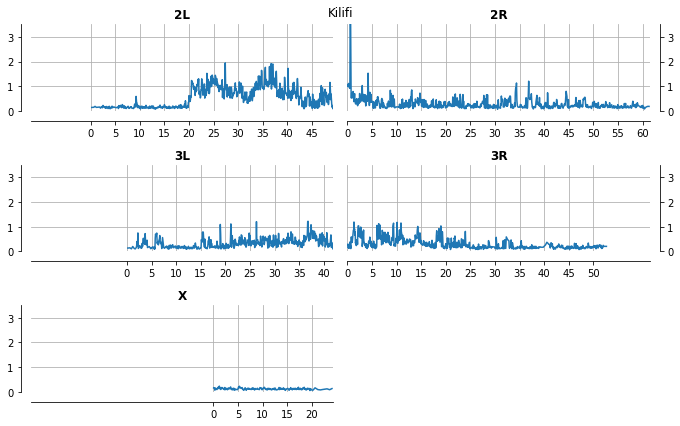

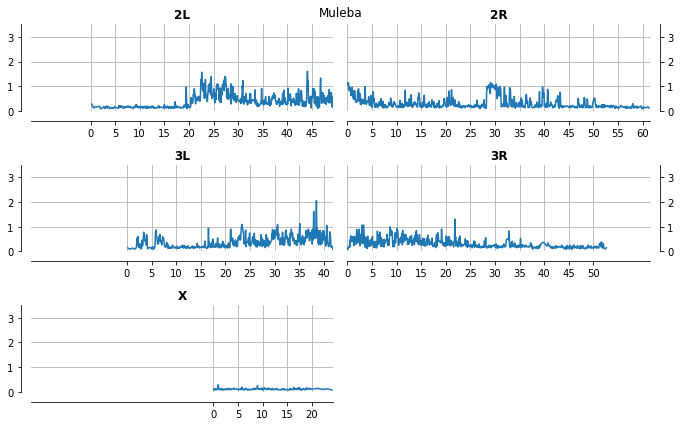

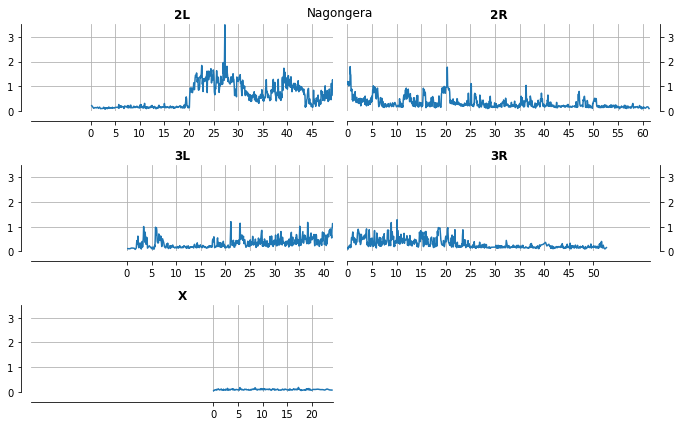

In [40]:
for _, location in sites_to_investigate:
    
    f = GenomeFigure(genome, chromosomes=chromosomes, figsize=(10, 6))
    f.apply(draw_introgression_relative, data=pd_dict, location=location)
    f.fig.suptitle(location)